# Taxi dataset

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## Dataset

In [2]:
df = pd.read_csv('taxi.csv')
df.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
0,2011-11-23 14:36:35.0000003,2011-11-23 14:36:35 UTC,-73.959075,40.783316,-73.959087,40.783345,1.0,2.5
1,2013-09-14 21:40:00.00000016,2013-09-14 21:40:00 UTC,-73.931612,40.771060,-73.929097,40.760542,1.0,5.5
2,2012-04-30 18:13:19.0000002,2012-04-30 18:13:19 UTC,-73.997929,40.740983,-74.007197,40.727725,2.0,6.5
3,2010-10-22 15:03:47.0000001,2010-10-22 15:03:47 UTC,-73.980608,40.742449,-73.985609,40.755807,1.0,6.5
4,2011-02-18 18:08:16.0000002,2011-02-18 18:08:16 UTC,-74.008884,40.720314,-73.983280,40.722350,1.0,12.1


In [3]:
df.shape

(615962, 8)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615962 entries, 0 to 615961
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                615962 non-null  object 
 1   pickup_datetime    615962 non-null  object 
 2   pickup_longitude   615962 non-null  float64
 3   pickup_latitude    615961 non-null  float64
 4   dropoff_longitude  615959 non-null  float64
 5   dropoff_latitude   615959 non-null  float64
 6   passenger_count    615961 non-null  float64
 7   fare_amount        615961 non-null  float64
dtypes: float64(6), object(2)
memory usage: 37.6+ MB


In [5]:
df.isna().sum()

key                  0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      1
dropoff_longitude    3
dropoff_latitude     3
passenger_count      1
fare_amount          1
dtype: int64

In [ ]:
df.dropna(inplace=True)

In [29]:
df['year'] = df['pickup_datetime'].apply(lambda x: x[:4]).astype('Int16')
df['month'] = df['pickup_datetime'].apply(lambda x: x[5:7]).astype('Int16')
df['day'] = df['pickup_datetime'].apply(lambda x: x[8:10]).astype('Int16')
df['hour'] = np.where(
    df['pickup_datetime'].apply(lambda x: x[11:13]).astype('Int16') < 30,
    df['pickup_datetime'].apply(lambda x: x[8:10]).astype('Int16'),
    df['pickup_datetime'].apply(lambda x: x[8:10]).astype('Int16') + 1
)
df['hour'] = df['hour'] % 24
df = df.drop(columns=['pickup_datetime'])
df['hour']

0         23
1         14
2          6
3         22
4         18
          ..
615956     1
615957     6
615958     7
615959     4
615960     7
Name: hour, Length: 615959, dtype: int16

### В какие годы совершались поездки?

In [30]:
df['year'].min(), df['year'].max()

(np.int16(2009), np.int16(2015))

### Корректировка названия столбцов

In [12]:
def correct_columns(name):
    return name.replace(' ', '_')
df.rename(columns=correct_columns, inplace=True)

## Machine Learning

In [39]:
X = df.drop(['fare_amount', 'key'], axis=1)
y = df['fare_amount']

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Decision Tree

In [41]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

dt_model = DecisionTreeRegressor(max_depth=3)
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)
r2_score(y_test, y_pred)

0.4998349394485503

array([0.31174679, 0.05099006, 0.63726315, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

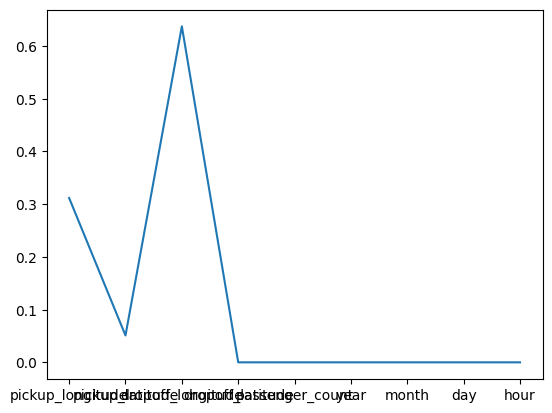

In [45]:
plt.plot(X.columns, dt_model.feature_importances_)
dt_model.feature_importances_

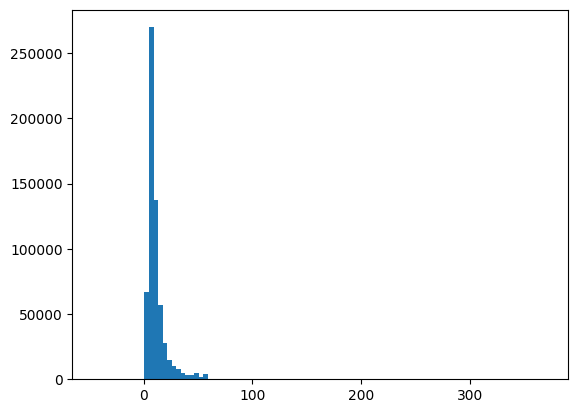

In [47]:
plt.hist(y, bins=100);

In [48]:
y = y.map(lambda x: 0 if x < 0 else x)
y = np.log1p(y)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [52]:
dt_model = DecisionTreeRegressor(max_depth=3)
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)
r2_score(np.expm1(y_test), np.expm1(y_pred))

0.44346012656888867

In [55]:
from sklearn.model_selection import GridSearchCV

params = {'max_depth': range(3, 11)}
gs = GridSearchCV(DecisionTreeRegressor(), param_grid=params, cv=3, scoring='r2')
gs.fit(X_train, y_train)
gs.best_estimator_

DecisionTreeRegressor(max_depth=10)

In [56]:
dt_model = gs.best_estimator_
y_pred = dt_model.predict(X_test)
r2_score(np.expm1(y_test), np.expm1(y_pred))

0.6868129250196828

### Pipeline

In [58]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

p1 = Pipeline([
    ('features', PolynomialFeatures(degree=2)),
    ('model', DecisionTreeRegressor(max_depth=3, random_state=42))
])

In [59]:
p1.fit(X_train, y_train)
y_pred = p1.predict(X_test)
r2_score(np.expm1(y_test), np.expm1(y_pred))

0.41732314222165745

In [60]:
params = {'model__max_depth': range(3, 11)}
gs = GridSearchCV(p1, param_grid=params, cv=3, scoring='r2')
gs.fit(X_train, y_train)
gs.best_estimator_

Pipeline(steps=[('features', PolynomialFeatures()),
                ('model',
                 DecisionTreeRegressor(max_depth=10, random_state=42))])

In [61]:
y_pred = gs.predict(X_test)
r2_score(np.expm1(y_test), np.expm1(y_pred))

0.7150519201658452